In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
from scipy import sparse
# from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
import pickle

/opt/anaconda3/envs/concord/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/concord/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/concord/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/concord/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/concord/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is dep

In [3]:
proj_name = "TabulaSapiens_n=300"
file_name = "TabulaSapiens_n=300"
file_suffix = time.strftime('%b%d-%H%M')
seed = 0

save_dir = Path(f"../save/{proj_name}-{file_suffix}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)

ccd.ul.set_seed(seed)

In [ ]:
adata =  sc.read_h5ad(data_dir / f"{file_name}_final.h5ad")

In [ ]:
adata

# upload obsm from h5 file

In [7]:
import h5py

h5_path = "../save/obsm_concord-1.0.6_0.4-0.4_Jul15/obsm_TabulaSapiens_Jul18-1643.h5"

def print_h5_structure(g, prefix=""):
    for key in g.keys():
        item = g[key]
        if isinstance(item, h5py.Group):
            print(f"{prefix}{key}/ (Group)")
            print_h5_structure(item, prefix=prefix + key + "/")
        elif isinstance(item, h5py.Dataset):
            print(f"{prefix}{key:50s} shape: {item.shape}")

with h5py.File(h5_path, 'r') as f:
    print_h5_structure(f)

obsm/ (Group)
obsm/concord_hcl_UMAP                                   shape: (1134472, 2)
obsm/concord_knn_UMAP                                   shape: (1134472, 2)
obsm/contrastive_UMAP                                   shape: (1134472, 2)
obsm/harmony_UMAP                                       shape: (1134472, 2)
obsm/scvi_UMAP                                          shape: (1134472, 2)
obsm/unintegrated_UMAP                                  shape: (1134472, 2)


In [ ]:
# obsm_keys_to_copy = [
#     "contrastive_UMAP", "contrastive_UMAP_3D",
#     "harmony_UMAP", "harmony_UMAP_3D",
#     "scanorama_UMAP", "scanorama_UMAP_3D",
#     "scvi_UMAP", "scvi_UMAP_3D",
#     "unintegrated_UMAP", "unintegrated_UMAP_3D",
#     "liger_UMAP", "liger_UMAP_3D",
# ]
obsm_keys_to_copy = [
    "concord_hcl_UMAP", 
    "concord_knn_UMAP", 
    "contrastive_UMAP", 
    "harmony_UMAP", 
    "scvi_UMAP", 
    "unintegrated_UMAP", 
]

In [ ]:
with h5py.File(h5_path, 'r') as f:
    obsm_group = f['obsm']
    for key in obsm_keys_to_copy:
        if key in obsm_group:
            data = obsm_group[key][:]
            assert data.shape[0] == adata.n_obs, f"Shape mismatch for {key}"
            print(f"✅ Appending: {key}")
            adata.obsm[key] = data
        else:
            print(f"⚠️  Skipped (not found): {key}")

In [ ]:
adata.write(data_dir / f"{file_name}_final.h5ad")

In [ ]:
adata

----

# time and memory profiling

In [5]:
methods = ["liger", "harmony", "scanorama", "scvi", "contrastive", "concord_knn", "concord_hcl"]
# methods = ["unintegrated", "liger", "harmony", "scanorama", "scvi", "contrastive", "concord_knn", "concord_hcl"]

In [6]:
from benchmark_utils import collect_benchmark_logs
bench_df = collect_benchmark_logs(proj_name, methods)

[⚠️ Warning] no runs found for liger
[⚠️ Warning] no runs found for scanorama


In [8]:
for method in methods:
    if method not in bench_df['method'].values:
        new_row = pd.DataFrame([{
            'method': method,
        }])
        bench_df = pd.concat([bench_df, new_row], ignore_index=True)


In [45]:
bench_df

,method,gpu_name,time_sec,ram_MB,vram_MB
0,harmony,Tesla T4,274.218107,1420.695312,0.000000
1,scvi,Tesla T4,612.755747,3309.269531,81.356445
2,contrastive,Tesla T4,500.577508,3338.957031,180.185059
3,concord_knn,Tesla T4,565.636108,6374.937500,186.492188
4,concord_hcl,Tesla T4,589.043361,3432.125000,166.137207
5,liger,NaN,NaN,NaN,NaN
6,scanorama,NaN,NaN,NaN,NaN


✅ Benchmark summary saved to: ../save/TabulaSapiens_n=300-Jul23-2355/benchmark_summary_Jul23-2355.tsv


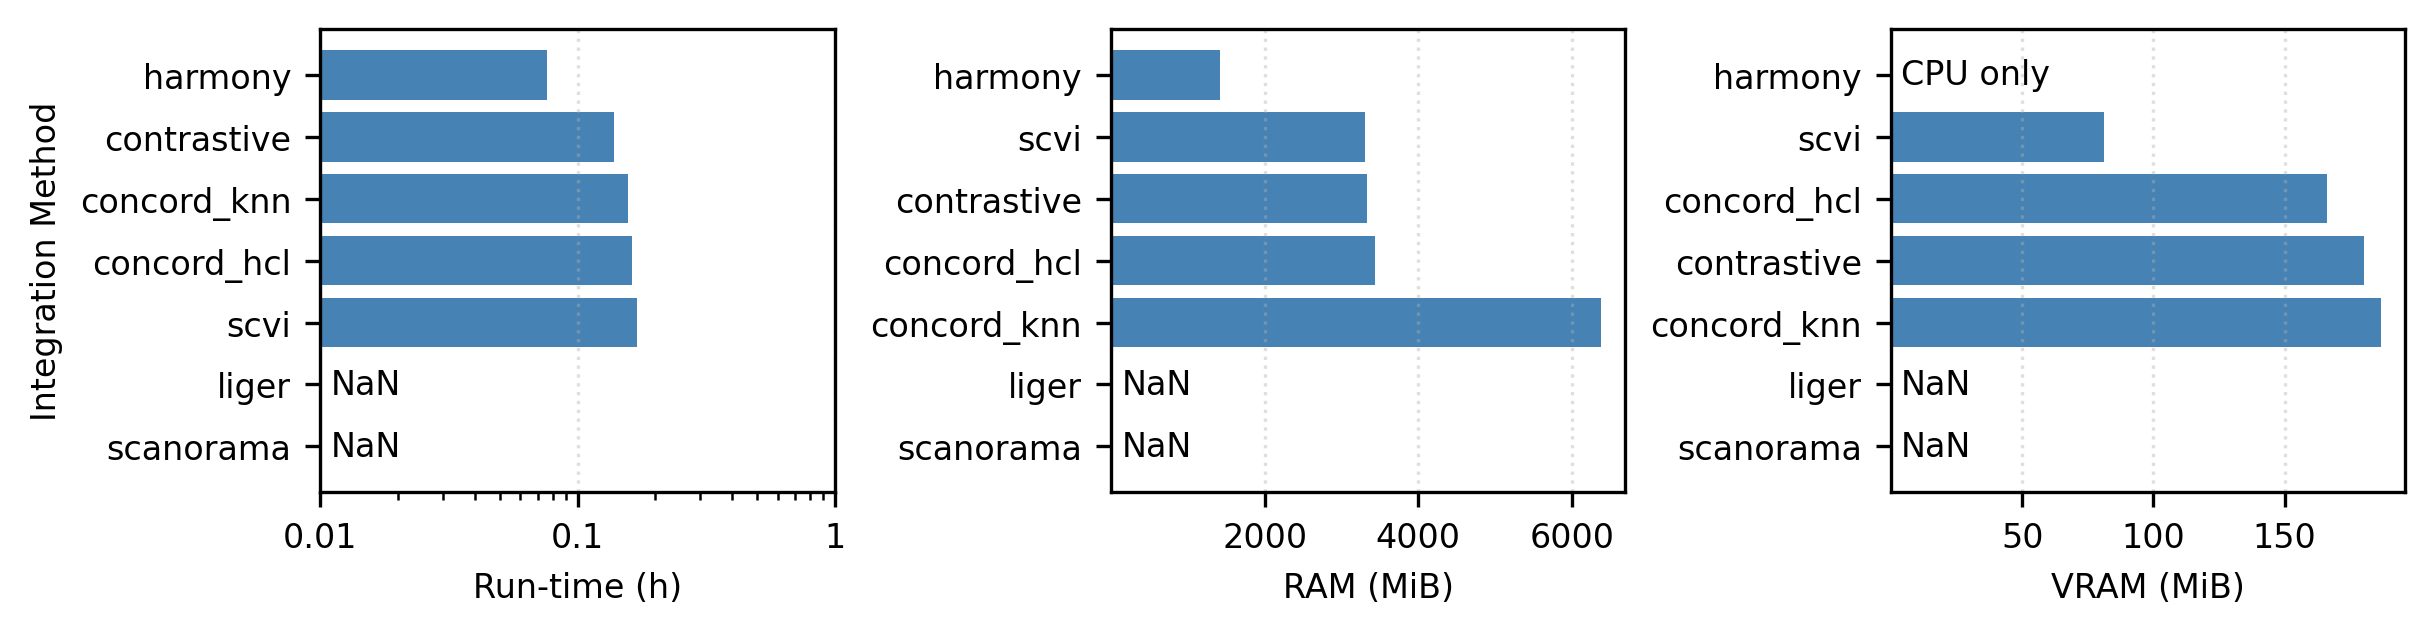

In [48]:
# Save the benchmark results
bench_df.to_csv(save_dir / f"benchmark_summary_{file_suffix}.tsv", sep="\t", index=False)
print(f"✅ Benchmark summary saved to: {save_dir / f'benchmark_summary_{file_suffix}.tsv'}")
# Plot benchmark results
from benchmark_utils import plot_benchmark_performance
import matplotlib.pyplot as plt
custom_rc = {
    'font.family': 'DejaVu Sans',  # Set the desired font for this plot
}
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(8,2), dpi=300, 
                               save_path = save_dir / f"benchmark_plot_{file_suffix}.pdf",
                               label_fontsize=8)


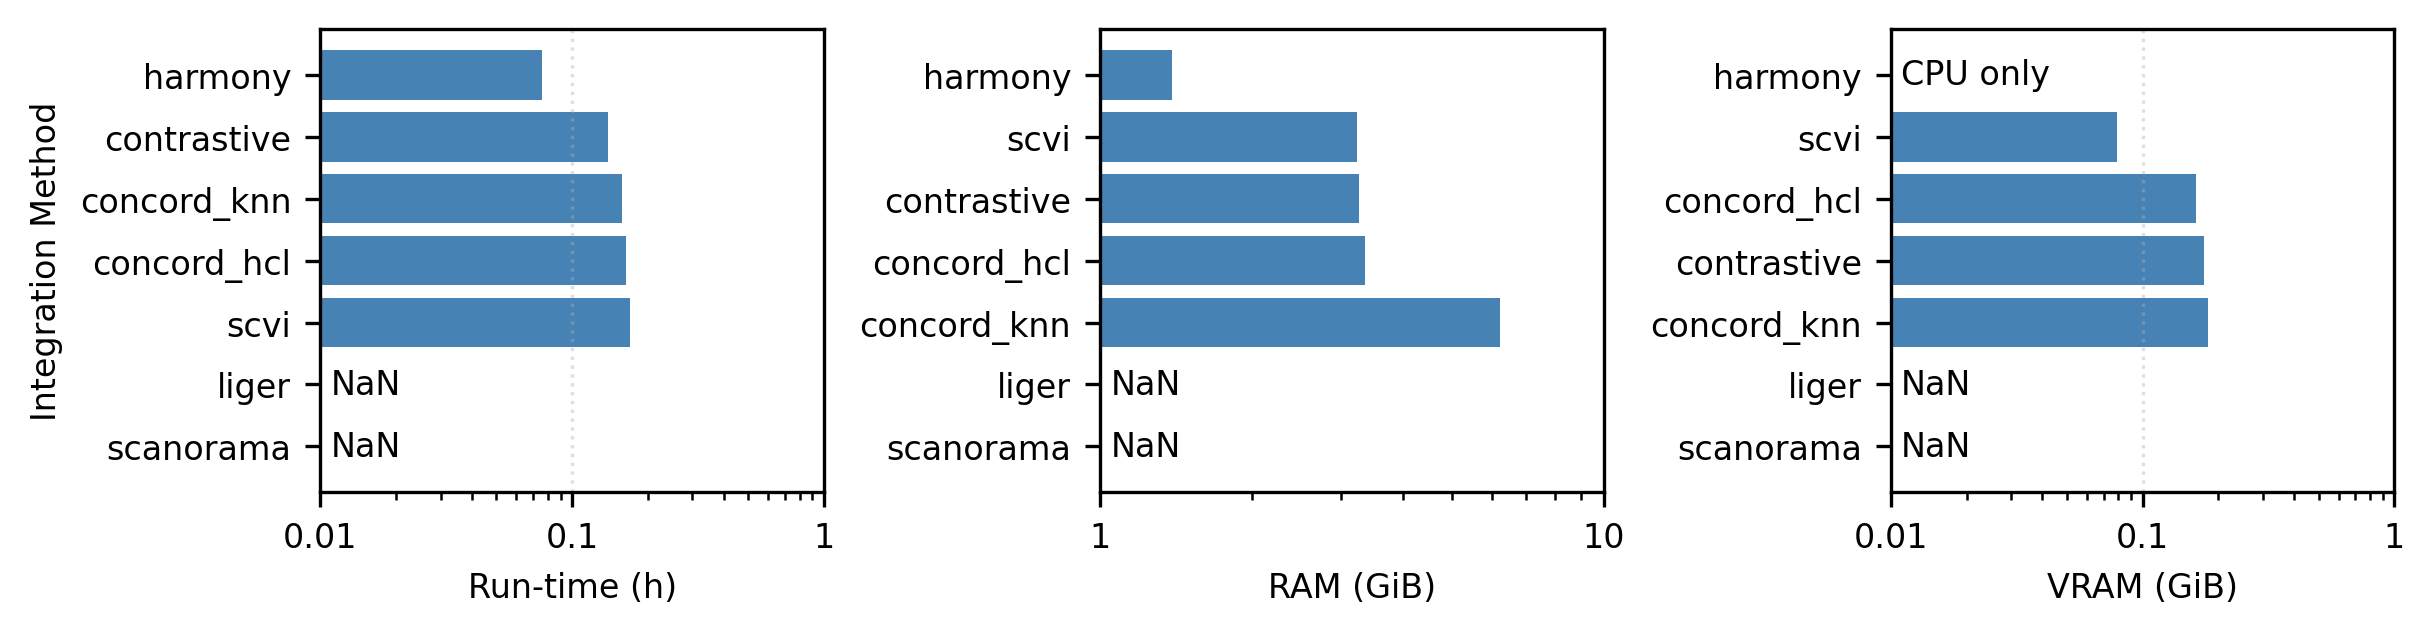

In [67]:
from benchmark_utils import plot_benchmark_performance
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(8,2), dpi=300, 
                               metric_scale = {"time_sec": "log", 
                                               "ram_MB": "log", 
                                               "vram_MB": "log", },
                                unit = "GiB",
                               save_path = save_dir / f"benchmark_plot_log_{file_suffix}.pdf",
                               label_fontsize=8,)

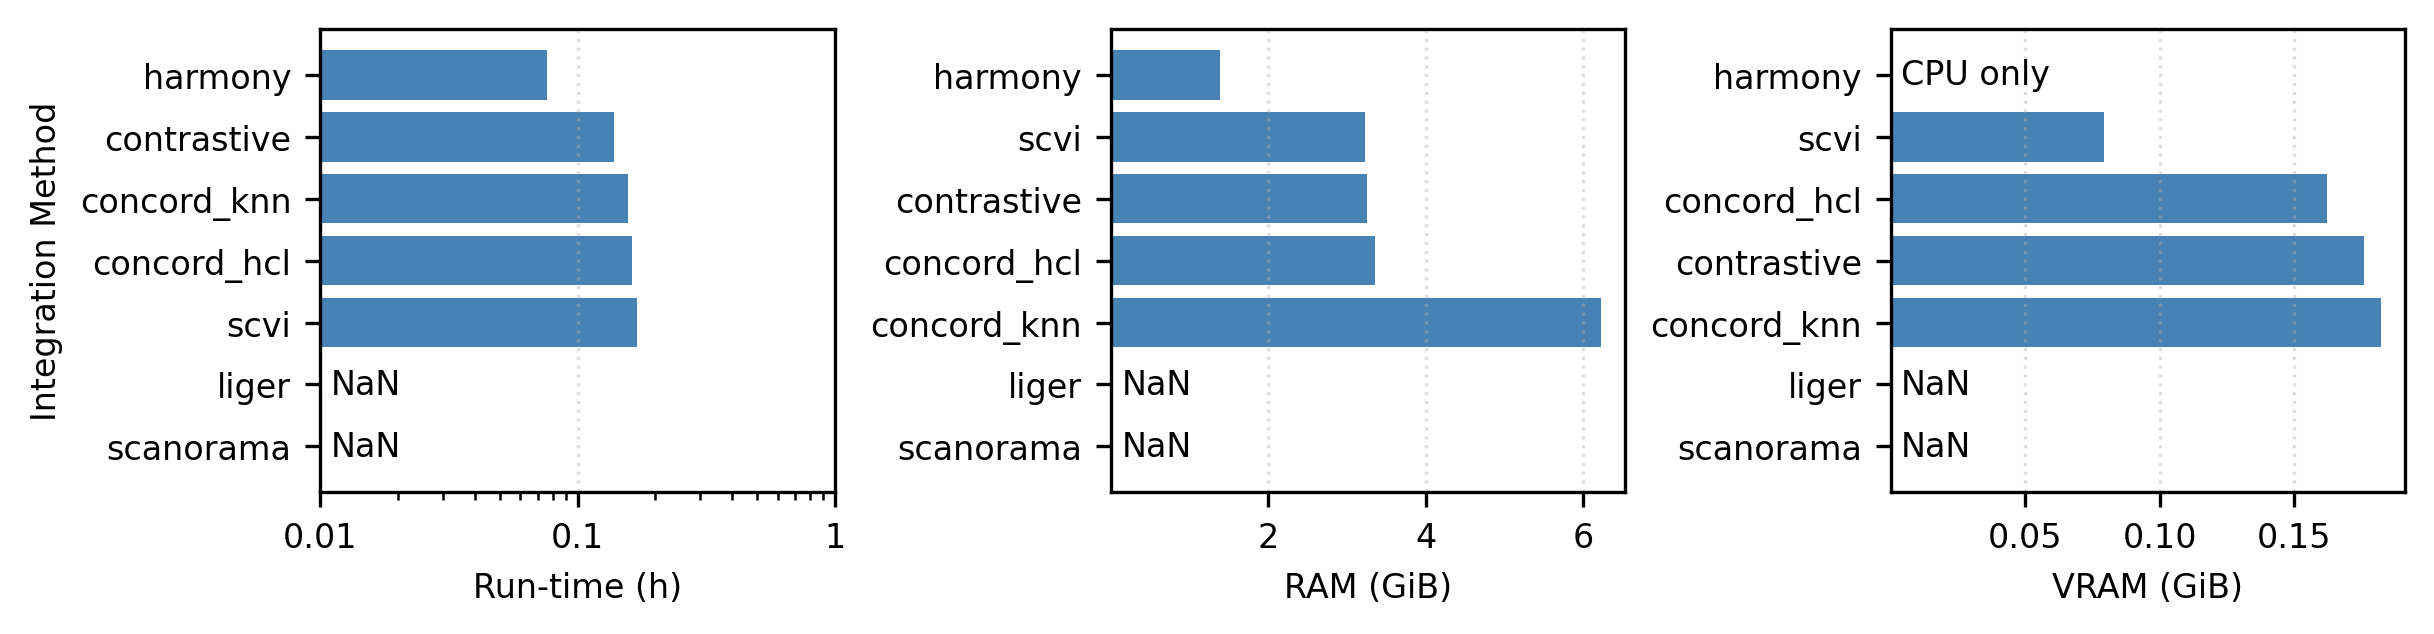

In [71]:
from benchmark_utils import plot_benchmark_performance
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(8,2), dpi=300, 
                               metric_scale = {"time_sec": "log", 
                                               "ram_MB": "linear", 
                                               "vram_MB": "linear", },
                                unit = "GiB",
                            #    save_path = save_dir / f"benchmark_plot_log_{file_suffix}.pdf",
                               label_fontsize=8,)

----

# UMAP

In [ ]:
methods = ["unintegrated", "harmony", "scvi", "contrastive", "concord_knn", "concord_hcl"]

batch_key = 'donor_assay'
state_key = 'cell_type'

In [ ]:
# plot everything
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import seaborn as sns

# Set DejaVu Sans as the default font
custom_rc = {
    'font.family': 'DejaVu Sans',  # Set the desired font for this plot
}

show_keys = methods
show_cols = [batch_key, state_key]
basis_types = ['UMAP']

font_size=10
point_size=1
alpha=0.8
ncols = len(show_keys)
figsize=(ncols * 1.5,1.5)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {}
for key in [batch_key, state_key]:
    n_categories = adata.obs[key].nunique()
    _, _, pal[key] = ccd.pl.get_color_mapping(adata,key, pal='tab20', seed=seed)

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix,
        dpi=600,
        save_format='svg'
    )


In [ ]:
show_basis = 'concord_hcl_UMAP'
show_cols = [batch_key, state_key]

pal = {}
for key in [batch_key, state_key]:
    n_categories = adata.obs[key].nunique()
    _, _, pal[key] = ccd.pl.get_color_mapping(adata,key, pal='tab20', seed=seed)
    
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, pal=pal, figsize=(25,15), dpi=600, ncols=2, font_size=10, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embedding_{show_basis}_{file_suffix}.svg"
)

In [ ]:
show_basis = 'concord_hcl_UMAP'
show_cols = [state_key]

pal = {}
for key in [state_key]:
    n_categories = adata.obs[key].nunique()
    _, _, pal[key] = ccd.pl.get_color_mapping(adata,key, pal='tab20', seed=seed)
    
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, pal=pal, figsize=(25,25), dpi=600, ncols=1, font_size=10, point_size=5, legend_loc=None,
    save_path=save_dir / f"embedding_{show_basis}_{state_key}_{file_suffix}.svg"
)

In [ ]:
show_basis = 'concord_knn_UMAP'
show_cols = [batch_key, state_key]

pal = {}
for key in [batch_key, state_key]:
    n_categories = adata.obs[key].nunique()
    _, _, pal[key] = ccd.pl.get_color_mapping(adata,key, pal='tab20', seed=seed)
    
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, pal=pal, figsize=(25,15), dpi=600, ncols=2, font_size=10, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embedding_{show_basis}_{file_suffix}.svg"
)

In [ ]:
show_basis = 'scvi_UMAP'
show_cols = [batch_key, state_key]

pal = {}
for key in [batch_key, state_key]:
    n_categories = adata.obs[key].nunique()
    _, _, pal[key] = ccd.pl.get_color_mapping(adata,key, pal='tab20', seed=seed)
    
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, pal=pal, figsize=(25,15), dpi=600, ncols=2, font_size=10, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embedding_{show_basis}_{file_suffix}.svg"
)

In [ ]:
adata.obs['broad_cell_class'].value_counts()

----

# combine the scib metrics results of all methods

In [5]:
import pickle as pkl

In [6]:
# upload the pickle files of bm_TabulaSapiens_n=300
# file_dir = Path("/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul16")
# file_dir = file_dir / "TabulaSapiens_n=300-Jul19"

file_dir = Path("/Volumes/Shared/Concord_backup/save/archive/results_concord-1.0.6_adjusted_metrics_Jul16_old/TabulaSapiens_n=300-Jul19")

file_path = file_dir / "TabulaSapiens_n=300-Jul20-0427/benchmark_cell_type_Jul20-0427.pkl"
with open(file_path, "rb") as f:
    bm_TabulaSapiens_n_300_scvi = pkl.load(f)

file_path = file_dir / "TabulaSapiens_n=300-Jul20-0928/benchmark_cell_type_Jul20-0928.pkl"
with open(file_path, "rb") as f:
    bm_TabulaSapiens_n_300_harmony = pkl.load(f)

file_path = file_dir / "TabulaSapiens_n=300-Jul21-0227/benchmark_cell_type_Jul21-0227.pkl"
with open(file_path, "rb") as f:
    bm_TabulaSapiens_n_300_unintegrated = pkl.load(f)

file_path = file_dir / "TabulaSapiens_n=300-Jul22-0005/benchmark_cell_type_Jul22-0005.pkl"
with open(file_path, "rb") as f:
    bm_TabulaSapiens_n_300_concord_knn = pkl.load(f)

file_path = file_dir / "TabulaSapiens_n=300-Jul22-0505/benchmark_cell_type_Jul22-0505.pkl"
with open(file_path, "rb") as f:
    bm_TabulaSapiens_n_300_concord_hcl = pkl.load(f)

file_path = file_dir / "TabulaSapiens_n=300-Jul22-2323/benchmark_cell_type_Jul22-2323.pkl"
with open(file_path, "rb") as f:
    bm_TabulaSapiens_n_300_contrastive = pkl.load(f)

In [7]:
# combine the scib metrics results of all methods
bm_TabulaSapiens_n_300 = [
    bm_TabulaSapiens_n_300_scvi,
    bm_TabulaSapiens_n_300_harmony,
    bm_TabulaSapiens_n_300_unintegrated,
    bm_TabulaSapiens_n_300_concord_knn,
    bm_TabulaSapiens_n_300_concord_hcl,
    bm_TabulaSapiens_n_300_contrastive
]

In [8]:
scib_all = pd.concat([res['scib'] for res in bm_TabulaSapiens_n_300], axis=0)
probe_all = pd.concat([res['probe'] for res in bm_TabulaSapiens_n_300], axis=0)
combined_all = pd.concat([res['combined'] for res in bm_TabulaSapiens_n_300], axis=0)

In [9]:
merged_result = {
    'scib': scib_all,
    'probe': probe_all,
    'combined': combined_all
}


In [10]:
merged_result['combined']

Batch correction                                     \
             Graph connectivity     iLISI      KBET PCR comparison   
scvi                   0.748229  0.008144  0.252526       0.185673   
harmony                 0.49412  0.007923  0.191273       0.785784   
unintegrated           0.586996  0.001141  0.231526       0.181485   
concord_knn            0.689067  0.017841  0.254628       0.919382   
concord_hcl            0.716303  0.013505  0.248993       0.850982   
contrastive            0.695755  0.009529  0.270972              0   

                              Bio conservation                  \
             Silhouette batch            cLISI Isolated labels   
scvi                 0.816884         0.999947         0.57223   
harmony              0.878509         0.999771        0.566307   
unintegrated         0.887139         0.999977        0.571042   
concord_knn          0.739686         0.999856        0.573378   
concord_hcl          0.797962          0.99991        0.550715   
contrastive          0.690122         0.999956        0.593666   

                                                                             \
             KNN state accuracy Leiden ARI Leiden NMI Linear state accuracy   
scvi                   0.895564     0.5925   0.787403              0.862354   
harmony                0.862491   0.592625   0.758088              0.822635   
unintegrated           0.905749   0.578097   0.778099              0.883377   
concord_knn            0.872302   0.574276   0.777344              0.868657   
concord_hcl            0.883281   0.583254     0.7712              0.881019   
contrastive            0.886079   0.458426   0.759258              0.875193   

                               Aggregate score                             
             Silhouette label Batch correction Bio conservation   Average  
scvi                 0.529604         0.402291         0.696337  0.575403  
harmony              0.497337         0.471522         0.682826  0.599993  
unintegrated         0.518345         0.377657         0.689112  0.562735  
concord_knn          0.481762         0.524121         0.681323  0.629744  
concord_hcl          0.476194         0.525549         0.676255  0.630315  
contrastive          0.512863         0.333276         0.664834  0.529884

In [45]:
save_dir = file_dir
file_suffix = time.strftime('%b%d-%H%M')

In [48]:
# save the merged results
with open(save_dir / f"benchmark_cell_type_{file_suffix}.pkl", "wb") as f:
    pkl.dump(merged_result, f)
print(f"✅ Merged benchmark results saved to: {save_dir / f'benchmark_cell_type_{file_suffix}.pkl'}")

✅ Merged benchmark results saved to: /Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul16/TabulaSapiens_n=300-Jul19/benchmark_cell_type_Jul23-2142.pkl


----

In [62]:
# reload the merged results
save_dir = file_dir
with open(save_dir / f"benchmark_cell_type_{file_suffix}.pkl", "rb") as f:
    bm_TabulaSapiens_n_300 = pkl.load(f)

In [63]:
bm_TabulaSapiens_n_300['combined']

Batch correction                                     \
             Graph connectivity     iLISI      KBET PCR comparison   
scvi                   0.748229  0.008144  0.252526       0.185673   
harmony                 0.49412  0.007923  0.191273       0.785784   
unintegrated           0.586996  0.001141  0.231526       0.181485   
concord_knn            0.689067  0.017841  0.254628       0.919382   
concord_hcl            0.716303  0.013505  0.248993       0.850982   
contrastive            0.695755  0.009529  0.270972              0   

                              Bio conservation                  \
             Silhouette batch            cLISI Isolated labels   
scvi                 0.816884         0.999947         0.57223   
harmony              0.878509         0.999771        0.566307   
unintegrated         0.887139         0.999977        0.571042   
concord_knn          0.739686         0.999856        0.573378   
concord_hcl          0.797962          0.99991        0.550715   
contrastive          0.690122         0.999956        0.593666   

                                                                             \
             KNN state accuracy Leiden ARI Leiden NMI Linear state accuracy   
scvi                   0.895564     0.5925   0.787403              0.862354   
harmony                0.862491   0.592625   0.758088              0.822635   
unintegrated           0.905749   0.578097   0.778099              0.883377   
concord_knn            0.872302   0.574276   0.777344              0.868657   
concord_hcl            0.883281   0.583254     0.7712              0.881019   
contrastive            0.886079   0.458426   0.759258              0.875193   

                               Aggregate score                             
             Silhouette label Batch correction Bio conservation   Average  
scvi                 0.529604         0.402291         0.696337  0.575403  
harmony              0.497337         0.471522         0.682826  0.599993  
unintegrated         0.518345         0.377657         0.689112  0.562735  
concord_knn          0.481762         0.524121         0.681323  0.629744  
concord_hcl          0.476194         0.525549         0.676255  0.630315  
contrastive          0.512863         0.333276         0.664834  0.529884

In [64]:
combined_df = bm_TabulaSapiens_n_300['combined']
# rank the methods by the Aggregate score: Average
combined_df = combined_df.sort_values(by=('Aggregate score', 'Average'), ascending=False)

save_dir = save_dir / "benchmarks_celltype"

print(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul16/TabulaSapiens_n=300-Jul19/benchmarks_celltype


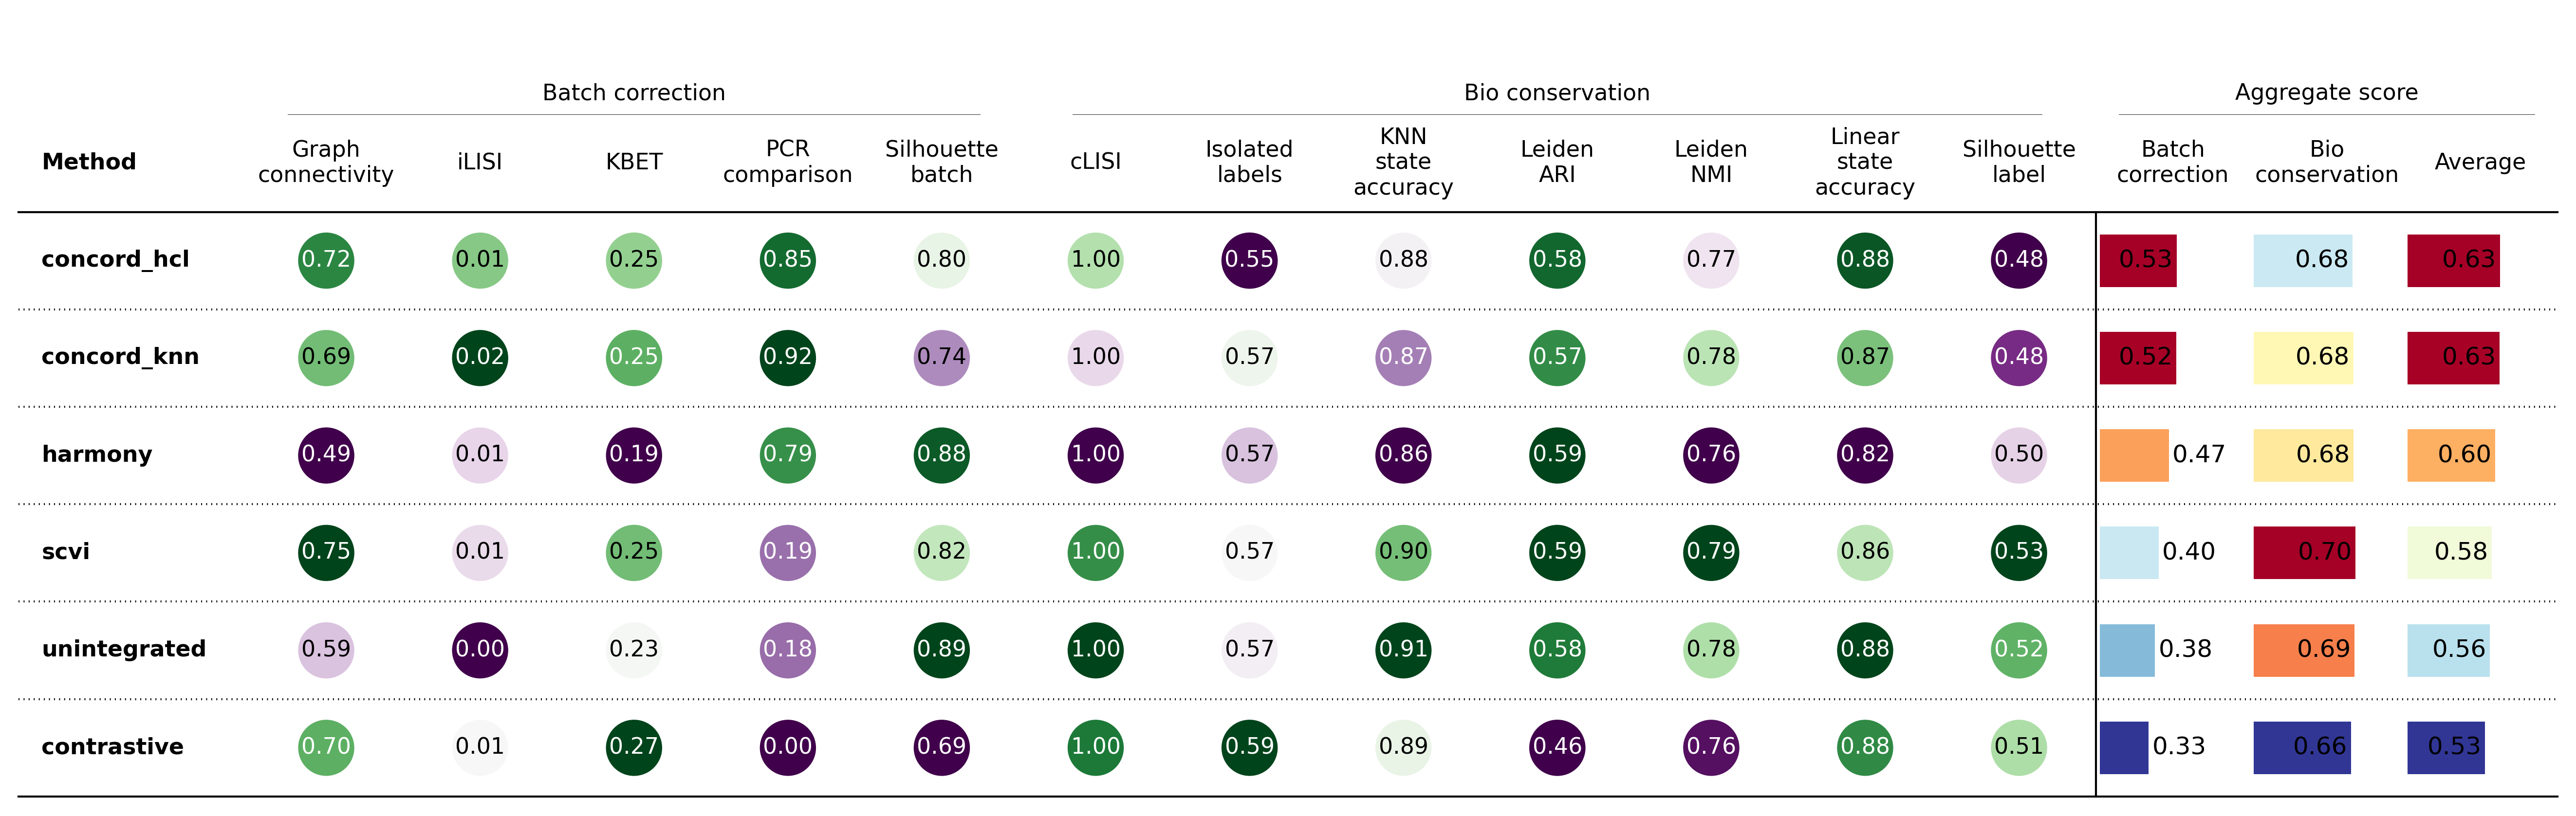

In [65]:
table_plot_kw = dict(
        pal="PRGn", pal_agg="RdYlBu_r", cmap_method="minmax", dpi=300)
ccd.pl.plot_benchmark_table(
    combined_df,
    save_path=save_dir / f"combined_res_{file_suffix}.pdf",
    agg_name="Aggregate score",
    figsize=(max(8, 1.5 * len(combined_df.columns)), 7),
    **table_plot_kw,

)